In [9]:
#import data
full_music_data <- read.csv("full_music_data.csv")
influence_data <- read.csv("influence_data.csv")
data_by_artist <- read.csv("data_by_artist.csv")
data_by_year <- read.csv("data_by_year.csv")
#remove unneeded columns from influence data, reorder columns
colnames(influence_data)
influence2 <- influence_data[, c(1, 5, 2, 3, 4, 6, 7, 8)]

[1] "influencer_id"           "influencer_name"        
[3] "influencer_main_genre"   "influencer_active_start"
[5] "follower_id"             "follower_name"          
[7] "follower_main_genre"     "follower_active_start"

In [11]:
library("igraph")

#reorder artist columns
colnames(data_by_artist)
artists2 <- data_by_artist[, c(2,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16)]

#Artist The New Pornographers are not included in the artist data, so we omit 
#them from the influence data as well in order to create a network graph
influence3 <- influence2[ -seq( from=22470, length.out=18, by=1), ]

#create network graph
net1 <- graph_from_data_frame(d=influence3, vertices=artists2, directed=T) 

[1] "artist_name"      "artist_id"        "danceability"     "energy"          
 [5] "valence"          "tempo"            "loudness"         "mode"            
 [9] "key"              "acousticness"     "instrumentalness" "liveness"        
[13] "speechiness"      "duration_ms"      "popularity"       "count"

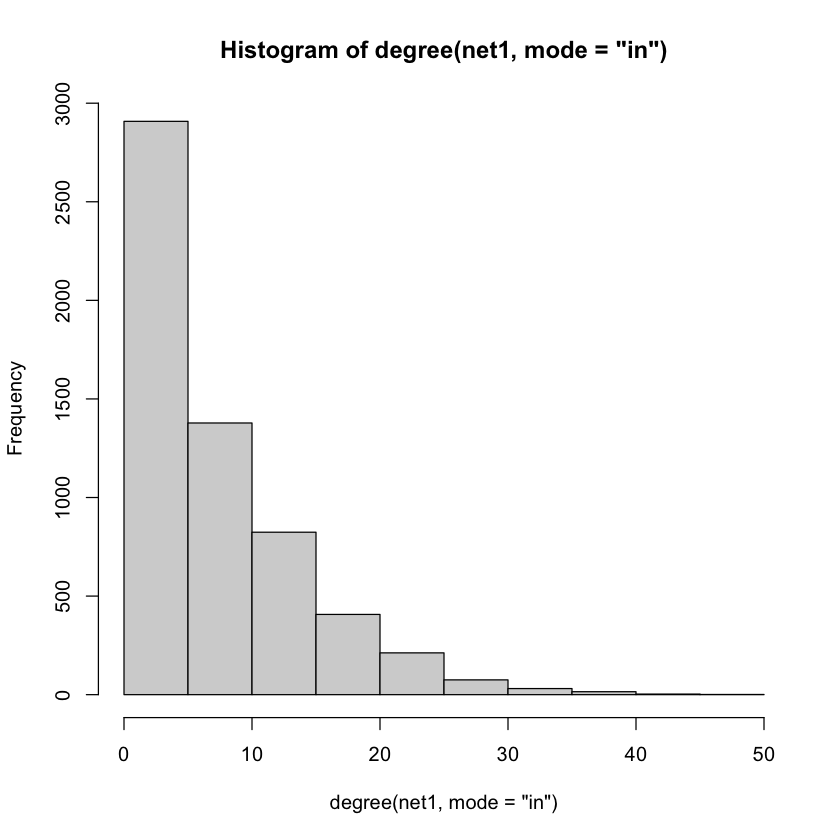

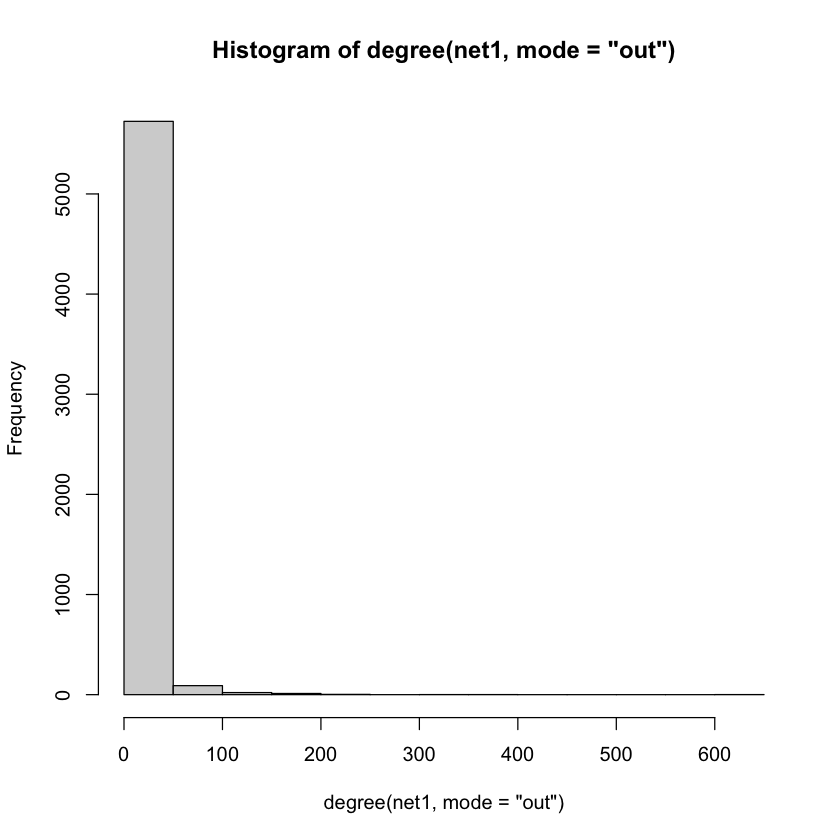

In [12]:
hist(degree(net1, mode = "in"))
hist(degree(net1, mode = "out"))

In [76]:
library(poweRlaw)

The following is taken from:
https://stats.stackexchange.com/questions/118334/power-law-fitting-and-testing
where none other than Aaron Clauset himself comments

and 

https://cran.r-project.org/web/packages/poweRlaw/vignettes/b_powerlaw_examples.pdf

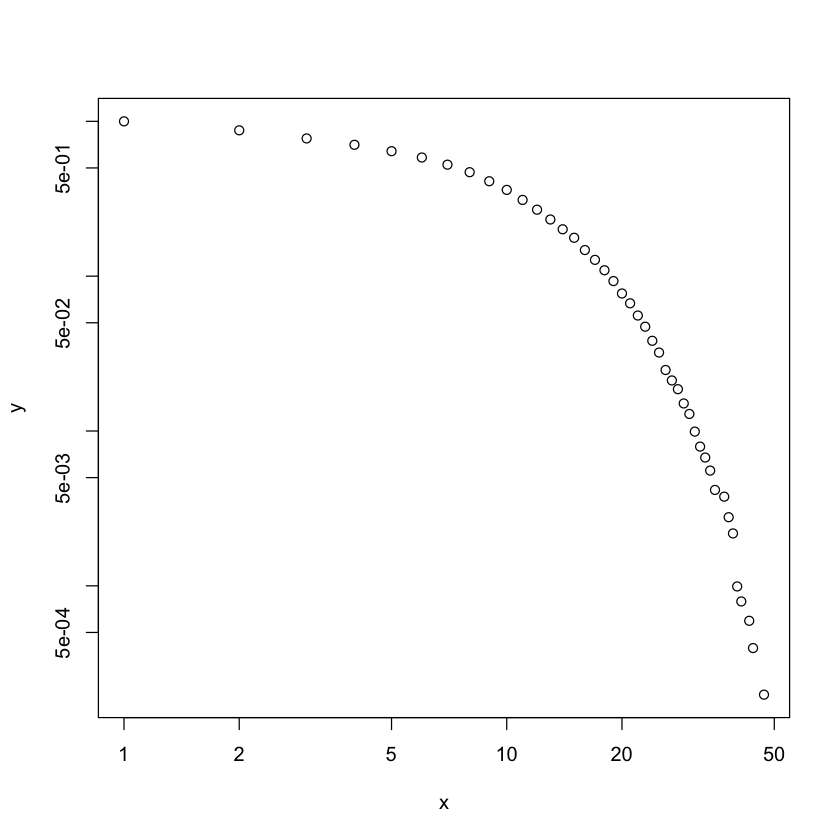

In [78]:
# Zeros were removed from the in degree distribution
no_zero_d = d[d!=0]
# Estimate the parameters xmin and α (in the plots they are k) of the power-law model using MLE.
m_pl = displ$new(no_zero_d)
est = estimate_xmin(m_pl)
m_pl$setXmin(est)
plot(m_pl)

In [85]:
m_ln = dislnorm$new(no_zero_d)
est = estimate_xmin(m_ln)
m_ln$setXmin(est)

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'lines': object 'm_pois' not found


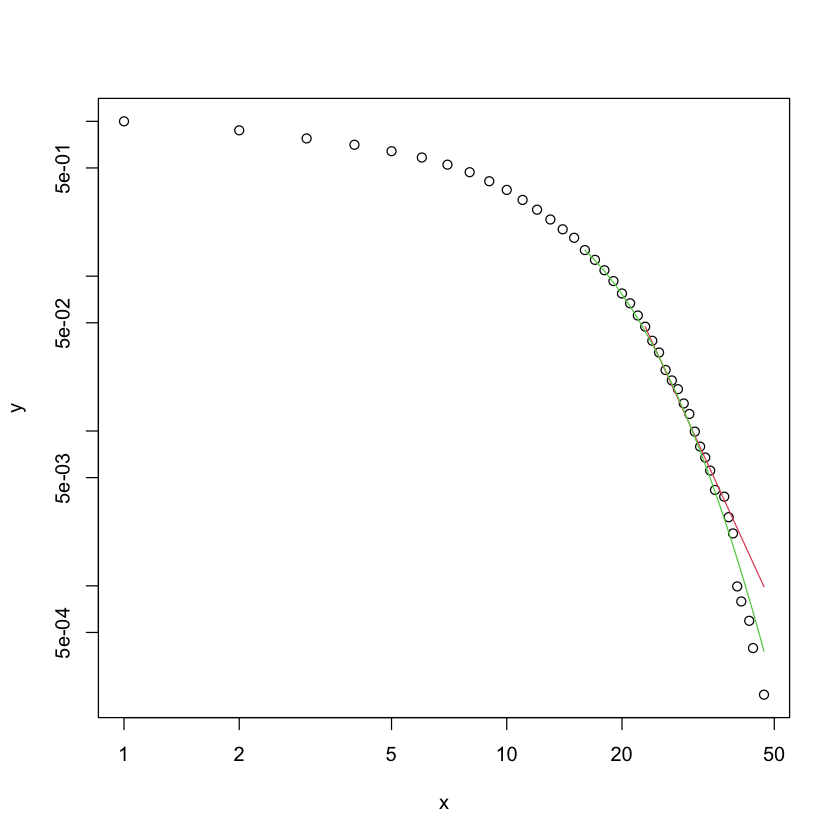

In [83]:
plot(m_pl)
lines(m_pl, col = 2)
lines(m_ln, col = 3)
lines(m_pois, col = 4)

From:
http://www.di.fc.ul.pt/~jpn/r/distributions/fitting.html#using-fitdistrplus

In [44]:
library(fitdistrplus)

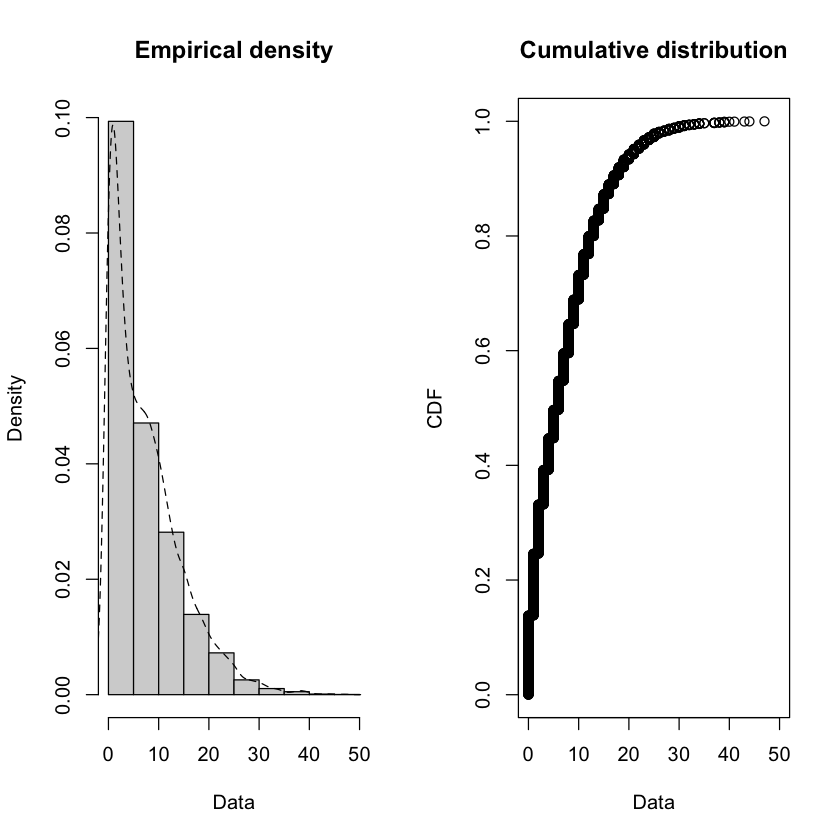

In [34]:
plotdist(d, histo = TRUE, demp = TRUE)

summary statistics
------
min:  0   max:  47 
median:  6 
mean:  7.303041 
estimated sd:  7.051135 
estimated skewness:  1.302486 
estimated kurtosis:  4.88191 

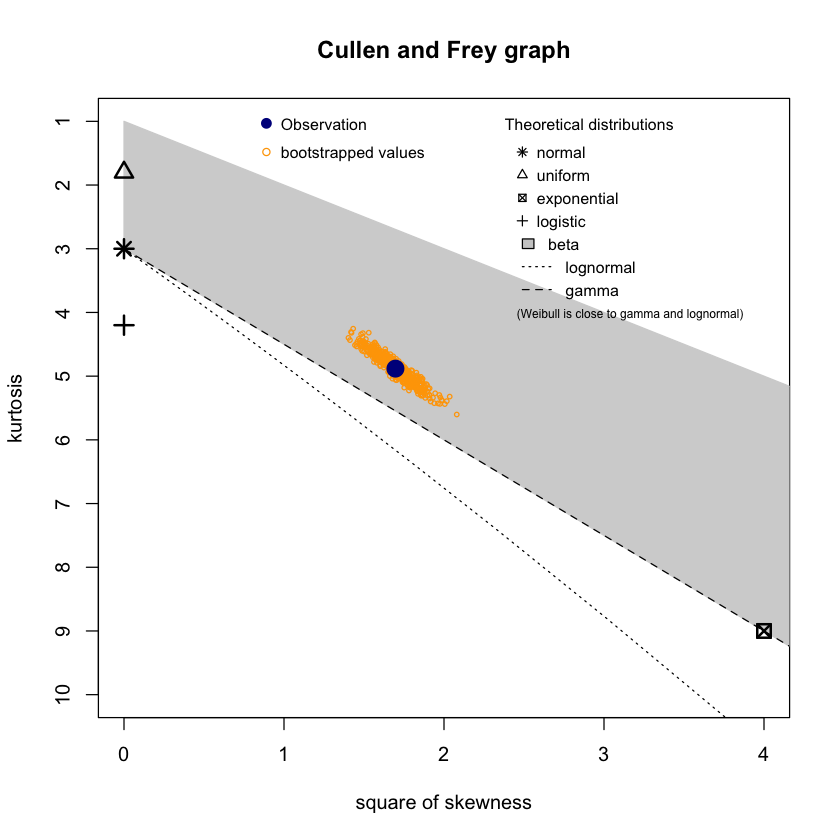

In [37]:
descdist(d, discrete=FALSE, boot=500)

fit_w, fit_g, and fit_ln all throw errors. Why?

In [59]:
# If I remove the zeros from the in degree distribution all appears well?
new_d = d[d!=0]

fit_w  <- fitdist(new_d, "weibull")
fit_g  <- fitdist(new_d, "gamma")
fit_ln <- fitdist(new_d, "lnorm")
summary(fit_ln)

Fitting of the distribution ' lnorm ' by maximum likelihood 
Parameters : 
         estimate Std. Error
meanlog 1.7503359 0.01352112
sdlog   0.9603804 0.00956083
Loglikelihood:  -15785.04   AIC:  31574.08   BIC:  31587.14 
Correlation matrix:
        meanlog sdlog
meanlog       1     0
sdlog         0     1


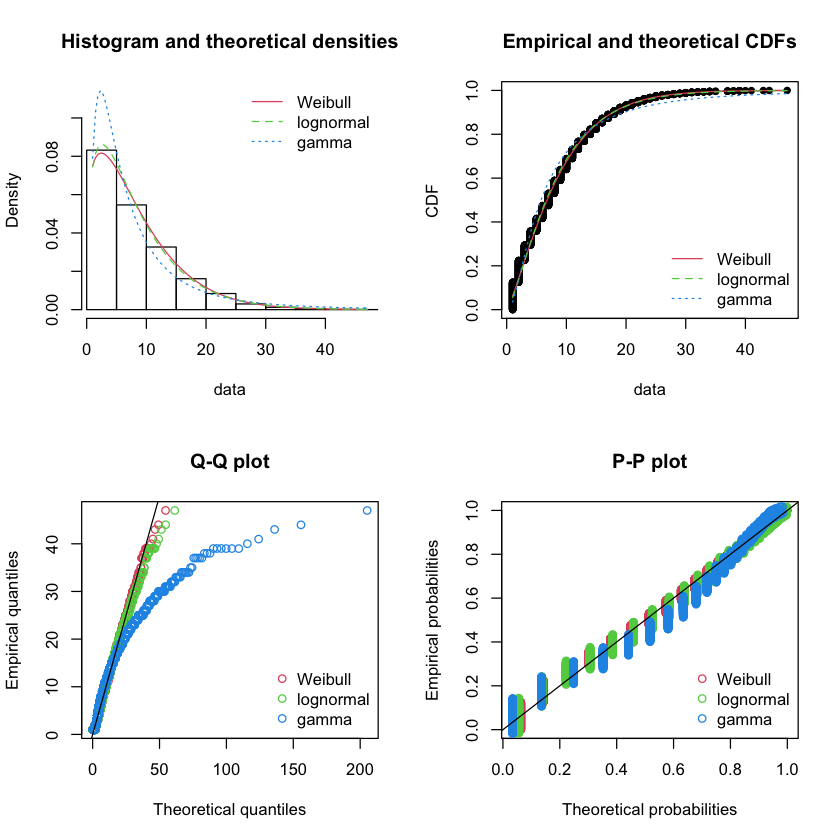

In [60]:
par(mfrow=c(2,2))
plot.legend <- c("Weibull", "lognormal", "gamma")
denscomp(list(fit_w, fit_g, fit_ln), legendtext = plot.legend)
cdfcomp (list(fit_w, fit_g, fit_ln), legendtext = plot.legend)
qqcomp  (list(fit_w, fit_g, fit_ln), legendtext = plot.legend)
ppcomp  (list(fit_w, fit_g, fit_ln), legendtext = plot.legend)

So, there seems to be a few non-powerlaw candidates.

See:
http://www.uvm.edu/pdodds/teaching/courses/2013-01UVM-300/docs/2013-01UVM-300lognormals-flat.pdf

In [47]:
library(actuar)

These also throw errors so I've used the in-degrees with zeros removed? Is this wise?

In [74]:
fit_ll <- fitdist(new_d, "llogis", start = list(shape = 1, scale = 500))
fit_P  <- fitdist(new_d, "pareto", start = list(shape = 1, scale = 500))
#fit_B  <- fitdist(new_d, "burr",   start = list(shape1 = 0.3, shape2 = 1, rate = 1))
#cdfcomp(list(fit_ln, fit_ll, fit_P, fit_B), xlogscale = TRUE, ylogscale = TRUE,
    #legendtext = c("lognormal", "loglogistic", "Pareto", "Burr"), lwd=2)
gofstat(list(fit_ln, fit_ll, fit_P), fitnames = c("lnorm", "llogis", "Pareto"))


Warning message in sqrt(diag(varcovar)):
“NaNs produced”
Warning message in sqrt(1/diag(V)):
“NaNs produced”
Warning message in cov2cor(varcovar):
“diag(.) had 0 or NA entries; non-finite result is doubtful”


Goodness-of-fit statistics
                                  lnorm     llogis     Pareto
Kolmogorov-Smirnov statistic  0.1057579  0.1033227  0.1111762
Cramer-von Mises statistic   12.0150137  9.1085519 10.2157739
Anderson-Darling statistic   85.6458291 78.3075859 73.9978311

Goodness-of-fit criteria
                                  lnorm   llogis   Pareto
Akaike's Information Criterion 31574.08 31864.14 31656.52
Bayesian Information Criterion 31587.14 31877.19 31669.58

The comments here:
https://stats.stackexchange.com/questions/132652/how-to-determine-which-distribution-fits-my-data-best
while pessimistic, are helpful.

See https://igraph.org/r/doc/fit_power_law.html

In [13]:
d <- degree(net1, mode="in")
fit1 <- fit_power_law(d+1, 10)
fit1$alpha
fit1$logLik
fit1$KS.stat
fit1$KS.p

[1] 3.144504

[1] -6125.479

[1] 0.09920573

[1] 4.033861e-18

In [14]:
fit2 <- fit_power_law(d+1, 10, implementation="R.mle")
stats4::coef(fit2)
stats4::logLik(fit2)

alpha 
3.14456

'log Lik.' -6125.478 (df=1)

From https://cran.r-project.org/web/packages/poweRlaw/vignettes/b_powerlaw_examples.pdf

From https://assemblingnetwork.wordpress.com/2013/06/10/network-basics-with-r-and-igraph-part-ii-of-iii/

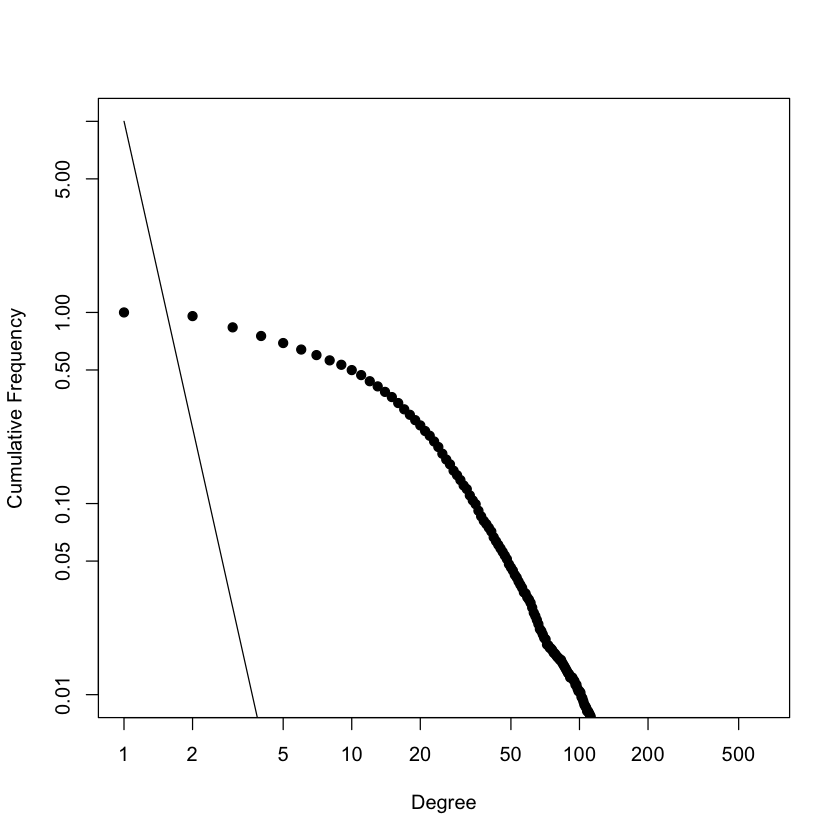

In [15]:
in.deg.testgraph<-degree(net1,v=V(net1),mode="in")

# Degree distribution is the cumulative frequency of nodes with a given degree
# this, like degree() can be specified as "in", "out", or "all"
deg.distr<-degree.distribution(net1,cumulative=T,mode="all")
 
# Using the power.law.fit() function I can fit a power law to the degree distribution
power<-power.law.fit(in.deg.testgraph)
 
# The output of the power.law.fit() function tells me what the exponent of the power law is ($alpha)
# and the log-likelihood of the parameters used to fit the power law distribution ($logLik)
# Also, it performs a Kolmogov-Smirnov test to test whether the given degree distribution could have
# been drawn from the fitted power law distribution.
# The function thus gives me the test statistic ($KS.stat) and p-vaule ($KS.p) for that test
 
# Then I can plot the degree distribution
plot(deg.distr,log="xy",
ylim=c(.01,10),
bg="black",pch=21,
xlab="Degree",
ylab="Cumulative Frequency")

# And the expected power law distribution
lines(1:20,10*(1:20)^((-power$alpha)+1))